In [1]:
import numpy as np
import pandas as pd
import os

In [2]:
# define a class including all parameter
class Para:
    method = 'SGD'
    month_in_sample = range(1,62 + 1) #return in-sample months
    month_test = range(63,124 + 1) #return test months
    percent_select = [0.3,0.3] # 30% positive samples, 30% NEGATIVE SAMPLES
    percent_cv = 0.1 #10% cross validation samples
    path_data = os.getcwd() + '\\csv\\'
    path_results = os.getcwd() + '\\results_demo\\'
    seed = 2019
    svm_kernel = 'linear'
    svm_c = 0.01
    #n_stock=100
para = Para()

In [3]:
def label_data(data):
    data['return_bin'] = np.nan
    data = data.sort_values(by = 'return',ascending = False)
    # decide how much stocks will be selected
    n_stock_select = np.multiply(para.percent_select,data.shape[0])
    n_stock_select = np.around(n_stock_select).astype(int)
    data.iloc[0:n_stock_select[0],-1] = 1
    data.iloc[-n_stock_select[1]:,-1] = 0
    data = data.dropna(axis=0)
    return data


In [4]:
#generate in-sample data
for i_month in para.month_in_sample:
    file_name = para.path_data + str(i_month) + '.csv'
    data_curr_month = pd.read_csv(file_name, header=0)
    para.n_stock = data_curr_month.shape[0]

    data_curr_month = data_curr_month.dropna(axis=0)
    # label data
    data_curr_month = label_data(data_curr_month)
    if i_month == para.month_in_sample[0]: 
        data_in_sample = data_curr_month
    else:
        data_in_sample = data_in_sample.append(data_curr_month)


In [5]:
# generate training and cv sets
X_in_sample = data_in_sample.loc[:, 'beta':'MFI14']
y_in_sample = data_in_sample.loc[:, 'return_bin']
from sklearn.model_selection import train_test_split
X_train, X_cv, y_train, y_cv = train_test_split(X_in_sample, y_in_sample, test_size=para.percent_cv, random_state=para.seed)
# PCA
from sklearn import decomposition
pca = decomposition.PCA(n_components=0.95)
pca.fit(X_train)
X_train = pca.transform(X_train) 
X_cv = pca.transform(X_cv)

# preprocessing if needed
from sklearn import preprocessing
scaler = preprocessing.StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_cv = scaler.transform(X_cv)

In [6]:
# set model
if para.method == 'SVM':
    from sklearn import svm
    model = svm.SVC(kernel=para.svm_kernel, C=para.svm_c)

In [7]:
# linear regression
if para.method == 'LR':
    from sklearn.linear_model import LinearRegression
    model = LinearRegression(fit_intercept=True)

In [8]:
# SGD
if para.method == 'SGD':
    from sklearn.linear_model import SGDClassifier
    model = SGDClassifier(loss='hinge',alpha=0.0001, penalty='l2',max_iter=5,random_state=para.seed)

In [9]:
pd.DataFrame(X_train).tail()

,0,1,2,3,4,5,6,7,8,9,...,32,33,34,35,36,37,38,39,40,41
63160,-0.376322,0.320067,-0.474921,0.124978,-0.182244,0.042212,0.352632,-0.291324,0.067967,0.224729,...,-0.083168,-0.155810,0.108620,0.053206,0.010589,-0.066789,-0.095065,-0.106353,-0.001726,0.153130
63161,0.592216,0.003314,0.089567,0.038706,0.054048,0.328894,-0.416053,0.037941,0.172967,-0.242727,...,0.033590,-0.079000,-0.153485,0.083440,-0.029578,-0.161227,-0.069810,-0.033663,0.025768,0.013461
63162,0.157879,0.099798,-0.231845,-0.153534,-0.303398,0.254478,-0.081837,0.118904,-0.075330,0.293264,...,0.000977,-0.025685,0.028774,0.079575,-0.023741,-0.005405,-0.036609,-0.005748,0.025131,-0.002103
63163,0.681678,-0.141078,-0.169412,-0.199964,0.116195,-0.467128,0.115479,0.147491,-0.010790,-0.363080,...,-0.001361,-0.032660,-0.156373,0.002750,0.081212,-0.025371,-0.019438,0.025826,0.080583,0.113353
63164,-0.390139,-0.033353,-0.230302,-0.231007,0.391002,-0.183638,-0.207227,0.079685,-0.140997,0.045754,...,0.029995,-0.052450,-0.052176,0.108017,-0.008841,-0.067840,0.076690,-0.063391,-0.014873,0.020901


In [10]:
if para.method == 'SVM':
    model.fit(X_train,y_train)
    y_pred_train = model.predict(X_train) 
    y_score_train = model.decision_function(X_train)
    y_pred_cv = model.predict(X_cv) 
    y_score_cv = model.decision_function(X_cv)

In [11]:
#linear regression
if para.method == 'LR':
    model.fit(X_train,y_train)
    y_score_train = model.predict(X_train)
    y_score_cv = model.predict(X_cv)

In [12]:
if para.method == 'SGD':
    model.fit(X_train,y_train)
    y_pred_train = model.predict(X_train) 
    y_score_train = model.decision_function(X_train)
    y_pred_cv = model.predict(X_cv) 
    y_score_cv = model.decision_function(X_cv)

In [13]:
# initialize
y_true_test = pd.DataFrame([np.nan] * np.ones((para.n_stock,para.month_test[-1])))
y_pred_test = pd.DataFrame([np.nan] * np.ones((para.n_stock,para.month_test[-1])))
y_score_test = pd.DataFrame([np.nan] * np.ones((para.n_stock,para.month_test[-1])))

In [15]:
# loop  for months
for i_month in para.month_test:
    file_name = para.path_data + str(i_month) + '.csv' 
    data_curr_month = pd.read_csv(file_name, header = 0)
    data_curr_month = data_curr_month.dropna(axis=0) #-- remove nan
    X_curr_month = data_curr_month.loc[:,'beta':'MFI14'] #-- generate X
    X_curr_month = pca.transform(X_curr_month) #-- pca
    
    # predict
    if para.method== 'SVM':
        y_pred_curr_month = model.predict(X_curr_month) 
        y_score_curr_month = model.decision_function(X_curr_month)
    # SGD + hinge
    if para.method == 'SGD':
        y_pred_curr_month = model.predict(X_curr_month) 
        y_score_curr_month = model.decision_function(X_curr_month)
        
    
    #save true and predicted return
    y_true_test.iloc[data_curr_month.index,i_month-1]=data_curr_month['return'][data_curr_month.index]
    y_pred_test.iloc[data_curr_month.index,i_month-1]=y_pred_curr_month
    y_score_test.iloc[data_curr_month.index,i_month-1]=y_score_curr_month

In [17]:
# linear regression
if para.method == 'LR':
    y_score_curr_month = model.predict(X_curr_mont)

124

In [16]:
# evaluate the training and cv sets
from sklearn import metrics
print('training set, accuracy = %.2f'%metrics.accuracy_score(y_train, y_pred_train)) 
print('training set, AUC = %.2f'%metrics.roc_auc_score(y_train, y_score_train))
print('cv set, accuracy = %.2f'%metrics.accuracy_score(y_cv, y_pred_cv)) 
print('cv set, AUC = %.2f'%metrics.roc_auc_score(y_cv, y_score_cv))

# evaluate the testing set by months
for i_month in para.month_test:
    y_true_curr_month = pd.DataFrame({'return':y_true_test.iloc[:,i_month-1]}) 
    y_pred_curr_month = y_pred_test.iloc[:,i_month-1]
    y_score_curr_month = y_score_test.iloc[:,i_month-1]
    
    # remove nan
    y_true_curr_month = y_true_curr_month.dropna(axis=0)
    
    #label data and select the best and worst 30% data
    y_curr_month = label_data(y_true_curr_month)['return_bin']
    y_pred_curr_month = y_pred_curr_month[y_curr_month.index] 
    y_score_curr_month = y_score_curr_month[y_curr_month.index]
    print('test set, month %d, accuracy = %.2f'%(i_month, metrics.accuracy_score(y_curr_month, y_pred_curr_month)))
    print('test set, month %d, AUC = %.2f'%(i_month, metrics.roc_auc_score(y_curr_month, y_score_curr_month)))


training set, accuracy = 0.54
training set, AUC = 0.56
cv set, accuracy = 0.52
cv set, AUC = 0.56
test set, month 63, accuracy = 0.55
test set, month 63, AUC = 0.63
test set, month 64, accuracy = 0.58
test set, month 64, AUC = 0.66
test set, month 65, accuracy = 0.47
test set, month 65, AUC = 0.38
test set, month 66, accuracy = 0.53
test set, month 66, AUC = 0.59
test set, month 67, accuracy = 0.57
test set, month 67, AUC = 0.62
test set, month 68, accuracy = 0.53
test set, month 68, AUC = 0.56
test set, month 69, accuracy = 0.53
test set, month 69, AUC = 0.54
test set, month 70, accuracy = 0.41
test set, month 70, AUC = 0.38
test set, month 71, accuracy = 0.53
test set, month 71, AUC = 0.54
test set, month 72, accuracy = 0.54
test set, month 72, AUC = 0.55
test set, month 73, accuracy = 0.53
test set, month 73, AUC = 0.52
test set, month 74, accuracy = 0.53
test set, month 74, AUC = 0.53
test set, month 75, accuracy = 0.53
test set, month 75, AUC = 0.55
test set, month 76, accuracy = 

In [17]:
# initialize a strategy
para.n_stock_select = 100
strategy = pd.DataFrame({'return':[0] * para.month_test[-1],'value':[1] * para.month_test[-1]})
for i_month in para.month_test:
    y_true_curr_month = y_true_test.iloc[:,i_month-1] 
    y_score_curr_month = y_score_test.iloc[:,i_month-1]
    y_score_curr_month = y_score_curr_month.sort_values(ascending=False)
    index_select = y_score_curr_month[0:para.n_stock_select].index
    strategy.loc[i_month-1,'return'] = np.mean(y_true_curr_month[index_select])
    strategy['value'] = (strategy['return']+1).cumprod()
    

E:\Anaconda3\lib\site-packages\pandas\core\indexing.py:1017: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return getattr(section, self.name)[new_key]


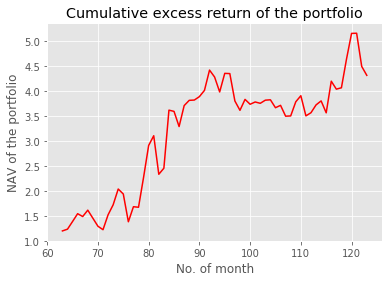

In [22]:
# plot the value
import matplotlib.pyplot as plt
plt.plot(para.month_test,strategy.loc[para.month_test,'value'],'r-') 
plt.style.use('ggplot')
plt.title('Cumulative excess return of the portfolio')
plt.xlabel('No. of month')
plt.ylabel('NAV of the portfolio')
plt.savefig('NAV_SGD.jpg',dpi=100)
plt.show()


In [20]:
# evaluation
ann_excess_return = np.mean(strategy.loc[para.month_test,'return']) * 12
ann_excess_vol = np.std(strategy.loc[para.month_test,'return']) * np.sqrt(12)
info_ratio = ann_excess_return/ann_excess_vol
print('annual excess return = %.2f'%ann_excess_return) 
print('annual excess volatility = %.2f'%ann_excess_vol) 
print('information ratio = %.2f'%info_ratio)


annual excess return = 0.37
annual excess volatility = 0.43
information ratio = 0.85


E:\Anaconda3\lib\site-packages\pandas\core\indexing.py:1017: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return getattr(section, self.name)[new_key]


In [23]:
# save resulrs
import os
if not os.path.exists(para.path_results): 
    os.makedirs(para.path_results)
    filename = para.path_results + 'dataTestYhat.csv'
    y_score_test.to_csv(filename,header=0,index=False)
